In [13]:
!pip install seaborn

In [14]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns

def load_dataset():
    dataset = pd.read_csv("googleplaystore.csv")
    return dataset

In [15]:
dataset= load_dataset()
dataset.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [16]:
def summarize_dataset(dataset):
    print(dataset.head())
    print(dataset.shape)
    print(dataset.describe())

In [17]:
summarize_dataset(dataset)

                                                 App        Category  Rating  \
0     Photo Editor & Candy Camera & Grid & ScrapBook  ART_AND_DESIGN     4.1   
1                                Coloring book moana  ART_AND_DESIGN     3.9   
2  U Launcher Lite – FREE Live Cool Themes, Hide ...  ART_AND_DESIGN     4.7   
3                              Sketch - Draw & Paint  ART_AND_DESIGN     4.5   
4              Pixel Draw - Number Art Coloring Book  ART_AND_DESIGN     4.3   

  Reviews  Size     Installs  Type Price Content Rating  \
0     159   19M      10,000+  Free     0       Everyone   
1     967   14M     500,000+  Free     0       Everyone   
2   87510  8.7M   5,000,000+  Free     0       Everyone   
3  215644   25M  50,000,000+  Free     0           Teen   
4     967  2.8M     100,000+  Free     0       Everyone   

                      Genres      Last Updated         Current Ver  \
0               Art & Design   January 7, 2018               1.0.0   
1  Art & Design;Pretend 

In [26]:
def clean_dataset(data):
    data = data.copy()
    
    data.loc[data['Installs'] == 'Free', 'Installs'] = '0'
    data['Installs'] = data['Installs'].str.replace('+', '').str.replace(',', '').astype(int)
    
    data.loc[data['Size'] == '1,000+', 'Size'] = '1000'
    data['Size'] = data['Size'].str.replace('M', '').str.replace('k', '').str.replace('Varies with device', '0').astype(float)
    
    
    data['Price'] = pd.to_numeric(data['Price'], errors='coerce')
    
    
    data['Reviews'] = data['Reviews'].str.replace('M', '').astype(float)
    
    data["Content Rating"] = data["Content Rating"].str.replace("+", "")
    
    return data

In [27]:
dataset = clean_dataset(dataset)
dataset.head()

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159.0,19.0,10000,Free,0.0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967.0,14.0,500000,Free,0.0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510.0,8.7,5000000,Free,0.0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644.0,25.0,50000000,Free,0.0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967.0,2.8,100000,Free,0.0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up


In [75]:
def histograms(dataset):
    top_categories = dataset['Category'].value_counts().head(10)

    # Pie chart
    plt.figure(figsize=(20, 10))
    plt.subplot(121)
    top_categories.plot(kind='pie', autopct='%1.f%%', wedgeprops={'linewidth': 2, 'edgecolor': 'black'}, shadow=True, fontsize=20)
    plt.title("Wise Distribution of Categories %")

    # Bar chart
    plt.subplot(122)
    top_categories.plot(kind='bar', color='blue')
    plt.title("Distribution of Categories")

    plt.show()

    # Count plot
    plt.figure(figsize=(12, 6))
    sns.countplot(data=dataset, x='Category')
    plt.ylabel("Number of Apps")
    plt.title("Number of Apps per Category", size=20)
    plt.xticks(rotation=90)
    plt.show()

    # Bar plot
    top_apps_max_price = dataset.groupby(['Category'])['Price'].max().nlargest(20).reset_index()
    sns.barplot(data=top_apps_max_price, x='Category', y='Price')
    plt.xticks(rotation=90)
    plt.title("Categories with Highest Price")
    plt.show()

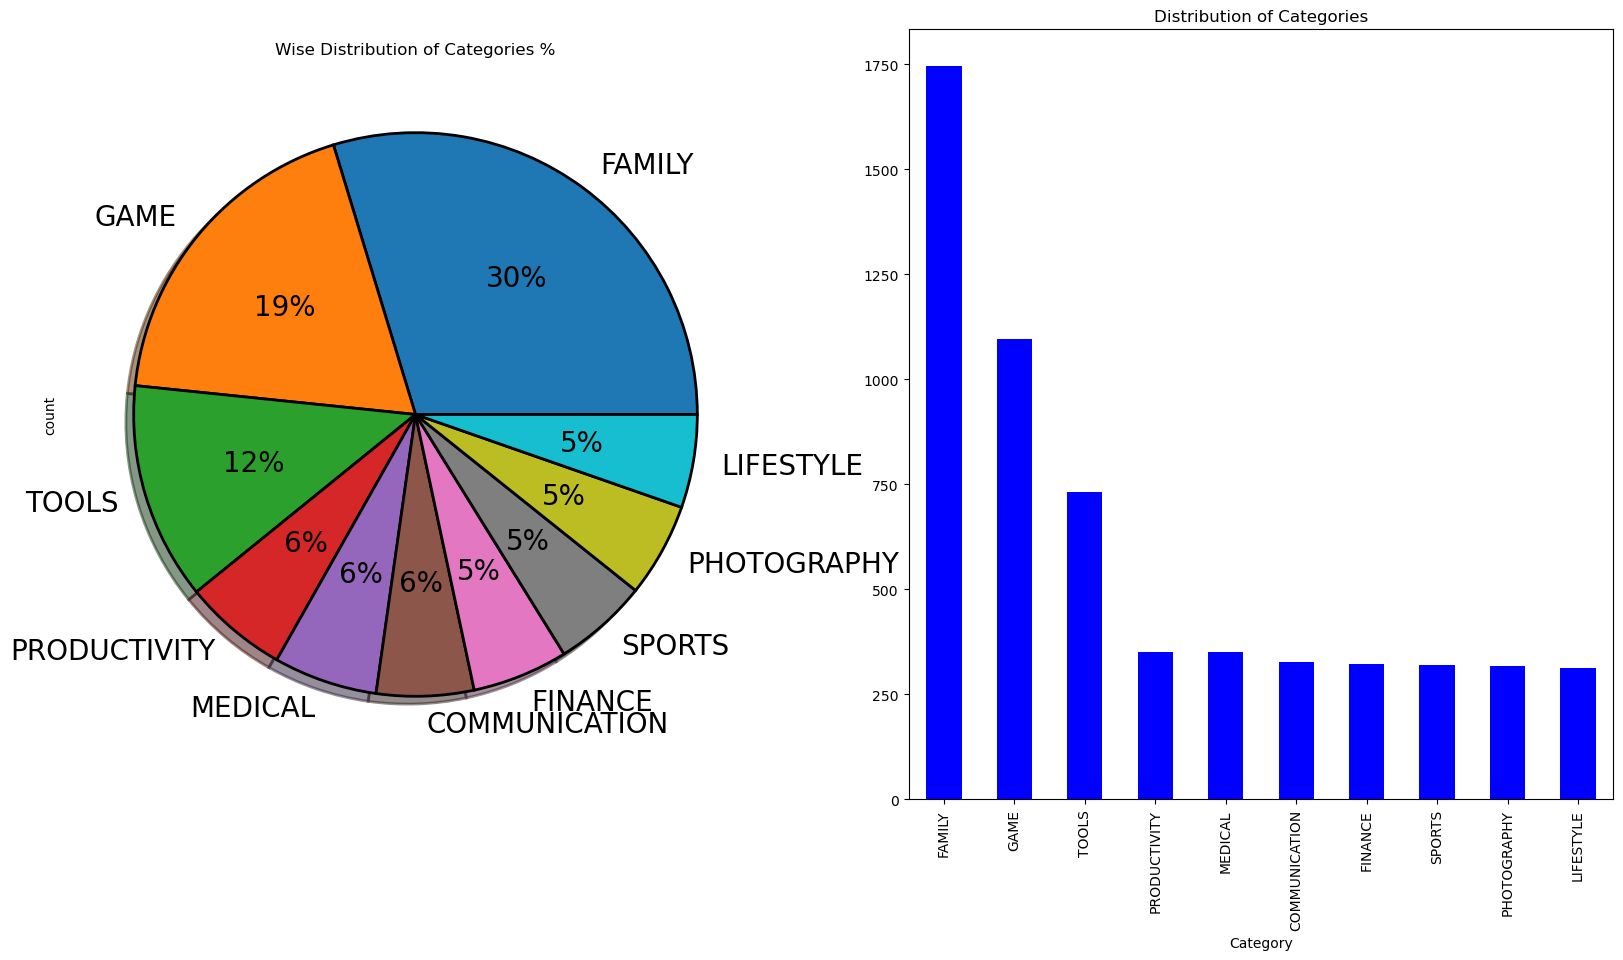

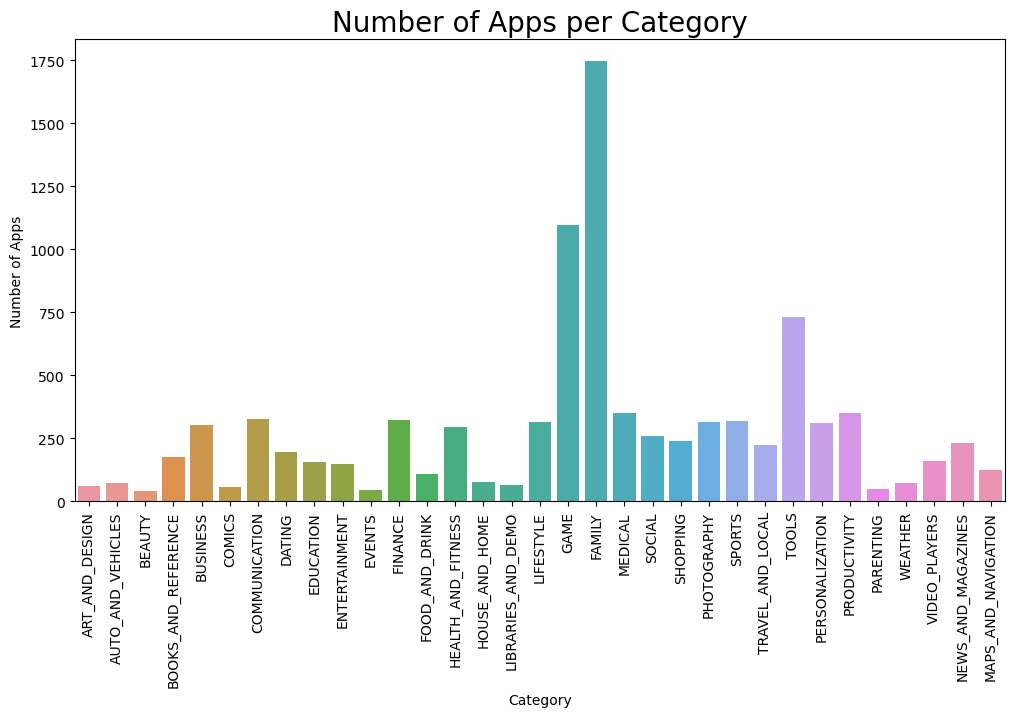

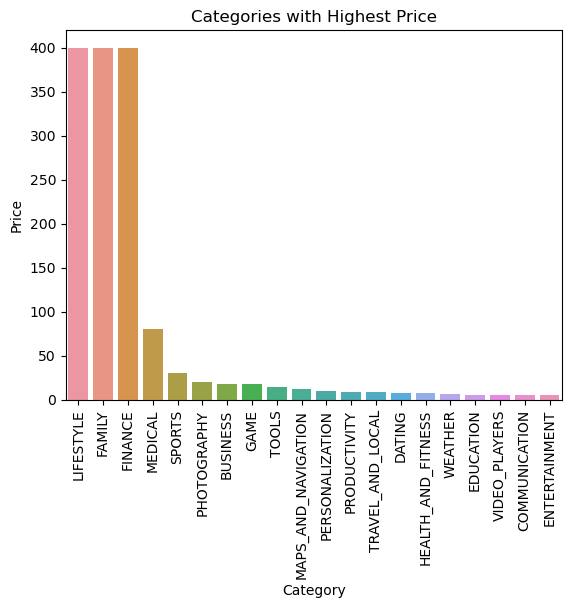

In [76]:
histograms(dataset)

In [95]:
def correlations_matrix(dataset):

    text_columns = dataset.select_dtypes(include=['object']).columns
    numeric_dataset = dataset.drop(columns=text_columns)
    correlation_matrix = numeric_dataset.corr()
    plt.figure(figsize=(10, 10))
    sns.heatmap(correlation_matrix, annot=True, cmap='viridis', linewidths=2)
    plt.title("Correlation Matrix")
    plt.show()


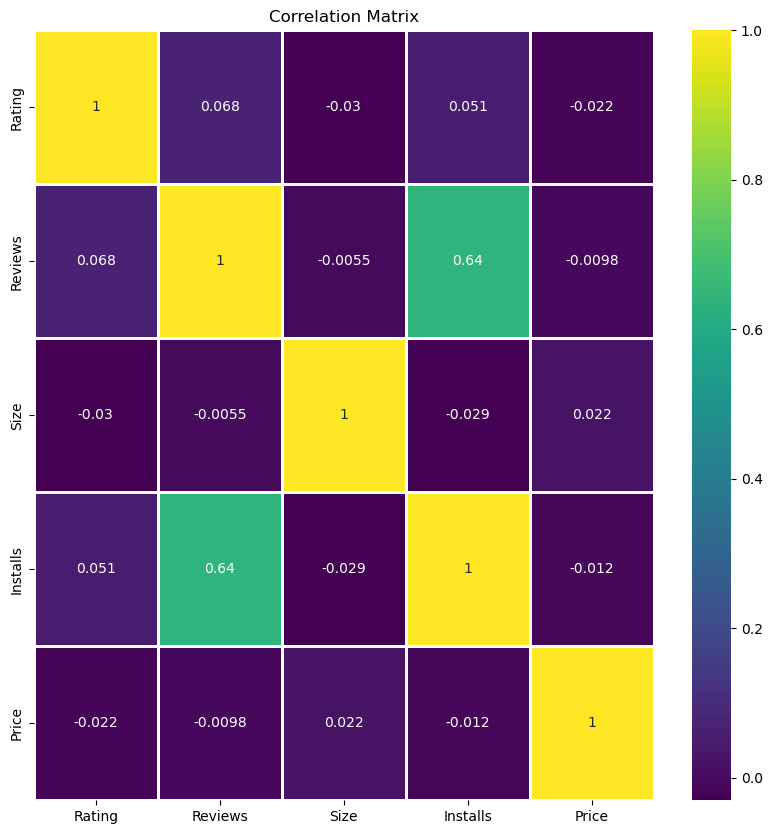

In [96]:
correlations_matrix(dataset)

In [101]:
def scatter_matrix(dataset):
    pd.plotting.scatter_matrix(dataset, alpha=1, figsize=(10, 10))
    plt.show()

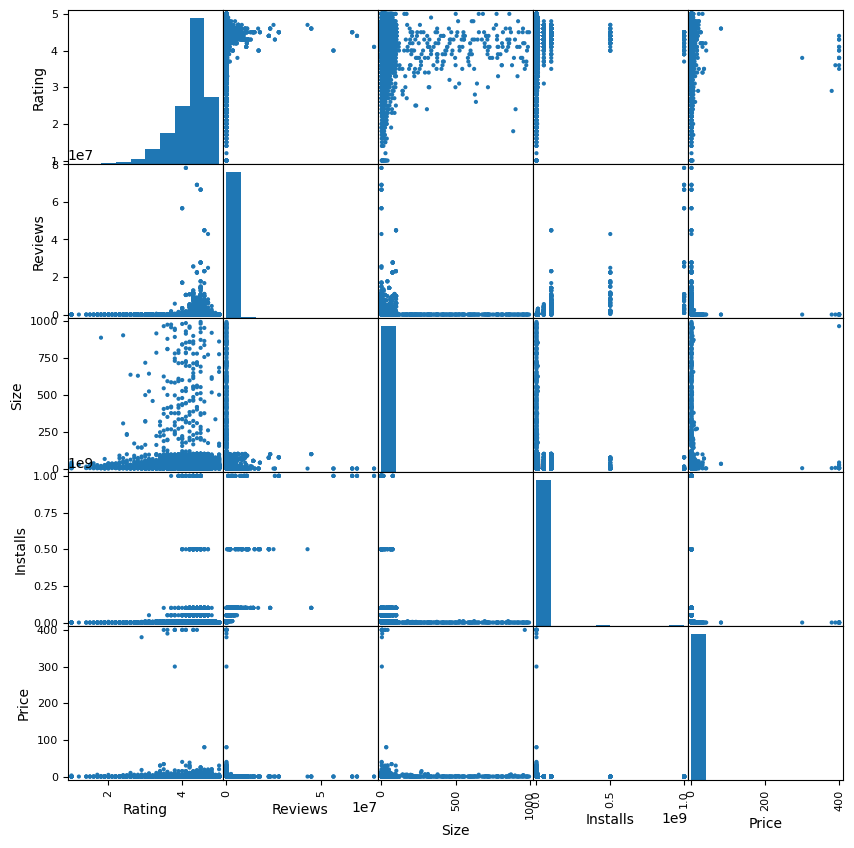

In [102]:
scatter_matrix(dataset)